In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from datetime import date
from datetime import timedelta
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = 16, 10

## Read the daily files
### NOTE: The Province/Region field is used inconsistently before 3/22.
###       If you read files before 3/22, only report at the country level.

In [2]:
base_path = 'csse_covid_19_data/csse_covid_19_daily_reports/'

#start = date.fromisoformat('2020-02-29')
start = date.fromisoformat('2020-03-22')  # prior to 3/22 the format is different and province/state has a mix of counties, and states, etc.
end = date.today()

df_all = pd.DataFrame(columns=['FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Last_Update',
                              'Lat', 'Long_', 'Confirmed', 'Deaths', 'Recovered', 'Active', 'Combined_Key'])

def rename_column_if_exists(df, old_col_name, new_col_name):
    if old_col_name in df.columns:
        df.rename(columns = {old_col_name: new_col_name}, inplace=True)
        
def str_join(df, sep, *cols):
    from functools import reduce
    return reduce(lambda x, y: x.astype(str).str.cat(y.astype(str), sep=sep), 
                    [df[col] for col in cols])

def create_combined_key_if_missing(df):
    if not 'Combined_Key' in df.columns:
        df.insert(len(df.columns), 'Combined_Key', np.NaN)
    df_missing = df['Combined_Key'].isna()
    df.loc[df_missing,'Combined_Key'] = df.loc[df_missing,:].Province_State.astype(str).str.cat(df.loc[df_missing,:].Country_Region.astype(str), sep=', ', na_rep='')
    
d = end - start
for dayindex in range(0,d.days+1):
    day = start + timedelta(days=dayindex)
    filename = '{:%m-%d-%Y}'.format(day)
    #print(base_path + filename + '.csv')
    try:
        df_input = pd.read_csv(base_path + filename + '.csv')
    except FileNotFoundError as e:
        print('FileNotFoundError - {}'.format(base_path + filename + '.csv'))
        continue
    rename_column_if_exists(df_input, 'Province/State', 'Province_State')
    rename_column_if_exists(df_input, 'Country/Region', 'Country_Region')
    rename_column_if_exists(df_input, 'Last Update', 'Last_Update')
    rename_column_if_exists(df_input, 'Latitude', 'Lat')
    rename_column_if_exists(df_input, 'Longitude', 'Long_')
    create_combined_key_if_missing(df_input)
    df_all = df_all.append(df_input)
    
df_all['Last_Update'] = pd.to_datetime(df_all.Last_Update) 
df_all['Last_Update'] = pd.to_datetime(df_all['Last_Update'].dt.date)  # the ".dt.date" collapses more granular datetime to just the day (so time-of-day differences aren't on different rows)
    
df_all.loc[df_all['Country_Region']=='Guatemala',:]


#df_raw = pd.read_csv('csse_covid_19_data/csse_covid_19_daily_reports/03-30-2020.csv')
#df_raw.head(30)

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
3345,NaN,NaN,NaN,Guatemala,2020-03-22,15.7835,-90.2308,19,1,0,18,Guatemala
3314,NaN,NaN,NaN,Guatemala,2020-03-23,15.7835,-90.2308,20,1,0,19,Guatemala
3314,NaN,NaN,NaN,Guatemala,2020-03-24,15.7835,-90.2308,21,1,0,20,Guatemala
3314,NaN,NaN,NaN,Guatemala,2020-03-25,15.7835,-90.2308,24,1,4,19,Guatemala
3313,NaN,NaN,NaN,Guatemala,2020-03-26,15.7835,-90.2308,25,1,4,20,Guatemala
3321,NaN,NaN,NaN,Guatemala,2020-03-27,15.7835,-90.2308,28,1,4,23,Guatemala
3321,NaN,NaN,NaN,Guatemala,2020-03-28,15.7835,-90.2308,34,1,10,23,Guatemala
3325,NaN,NaN,NaN,Guatemala,2020-03-29,15.7835,-90.2308,34,1,10,23,Guatemala
3330,NaN,NaN,NaN,Guatemala,2020-03-30,15.7835,-90.2308,36,1,10,25,Guatemala
2324,NaN,NaN,NaN,Guatemala,2020-03-31,15.7835,-90.2308,38,1,12,25,Guatemala


In [3]:
# Clean it up -- drop unneeded columns and set date as the index
df_clean = df_all.drop(labels=['FIPS', 'Lat', 'Long_'], axis=1)
df_clean = df_clean.melt(id_vars=['Admin2', 'Province_State', 'Country_Region', 'Combined_Key', 'Last_Update'],
            var_name='Metric',
            value_name='Value')
df_clean = df_clean.set_index('Last_Update')
df_clean.loc[df_clean['Country_Region']=='Guatemala'].tail()

,Admin2,Province_State,Country_Region,Combined_Key,Metric,Value
Last_Update,,,,,,
2020-04-02,NaN,NaN,Guatemala,Guatemala,Active,34
2020-04-03,NaN,NaN,Guatemala,Guatemala,Active,37
2020-04-04,NaN,NaN,Guatemala,Guatemala,Active,44
2020-04-05,NaN,NaN,Guatemala,Guatemala,Active,44
2020-04-06,NaN,NaN,Guatemala,Guatemala,Active,52


In [4]:
# Examples of dealing with the data in this format

# Just the death information for Santa Clara County
df_clean.loc[(df_clean.Admin2 == 'Santa Clara') & (df_clean.Metric == 'Deaths')]

# Just Confirmed Cases for Canadian Provinces
df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]

# Get the above (confirmed for Canadian Provinces) ready to graph (wide format with column labels being location)
(df_clean.loc[(df_clean.Metric == 'Confirmed') & (df_clean.Country_Region == 'Canada'), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum) #pivot() doesn't work because of duplicate indices
)

Province_State,Alberta,British Columbia,Diamond Princess,Grand Princess,Manitoba,New Brunswick,Newfoundland and Labrador,Northwest Territories,Nova Scotia,Ontario,Prince Edward Island,Quebec,Recovered,Saskatchewan,Yukon
Last_Update,,,,,,,,,,,,,,,
2020-03-22,259.0,424.0,0.0,13.0,20.0,17.0,9.0,1.0,28.0,425.0,3.0,219.0,NaN,52.0,NaN
2020-03-23,301.0,472.0,0.0,13.0,20.0,17.0,24.0,NaN,41.0,503.0,3.0,628.0,NaN,66.0,NaN
2020-03-24,359.0,617.0,0.0,13.0,21.0,18.0,35.0,NaN,51.0,588.0,3.0,1013.0,0.0,72.0,NaN
2020-03-25,358.0,617.0,0.0,13.0,35.0,18.0,35.0,NaN,68.0,688.0,5.0,1342.0,0.0,72.0,NaN
2020-03-26,486.0,725.0,0.0,13.0,36.0,33.0,82.0,1.0,73.0,858.0,5.0,1632.0,0.0,95.0,3.0
2020-03-27,542.0,725.0,0.0,13.0,39.0,45.0,102.0,1.0,90.0,994.0,9.0,2024.0,0.0,95.0,3.0
2020-03-28,542.0,884.0,0.0,13.0,64.0,51.0,120.0,1.0,110.0,1144.0,11.0,2498.0,0.0,134.0,4.0
2020-03-29,621.0,884.0,0.0,13.0,72.0,66.0,135.0,1.0,122.0,1355.0,11.0,2840.0,0.0,156.0,4.0
2020-03-30,661.0,970.0,0.0,13.0,96.0,68.0,148.0,1.0,127.0,1706.0,18.0,3430.0,0.0,156.0,4.0


### Label_lines routine - now with tuple_selector option

In [5]:
def label_lines(df, ax, tuple_selector=None, print_value=False):
    '''Labels lines in a chart assuming that some lines will be different lengths than others
       If tuple_selector is set to an integer, use it as an index to the label'''
    for label, series in df.items():
        prev_x = series.index[0]
        prev_data = series.iloc[0]
        for index, data in series.items():
            if pd.isnull(data):
                break
            prev_x = index
            prev_data = data
        if not (tuple_selector is None):
            if print_value:
                label = '{} ({:,})'.format(label[tuple_selector], int(prev_data))
            else:
                label = label[tuple_selector]
        else:
            if print_value:
                label = '{} ({:,})'.format(label, int(prev_data))
        ax.annotate(label, (prev_x, prev_data),
                            xytext=(10,0), 
                            textcoords='offset pixels',
                            family='sans-serif', fontsize=14, color='darkslategrey')

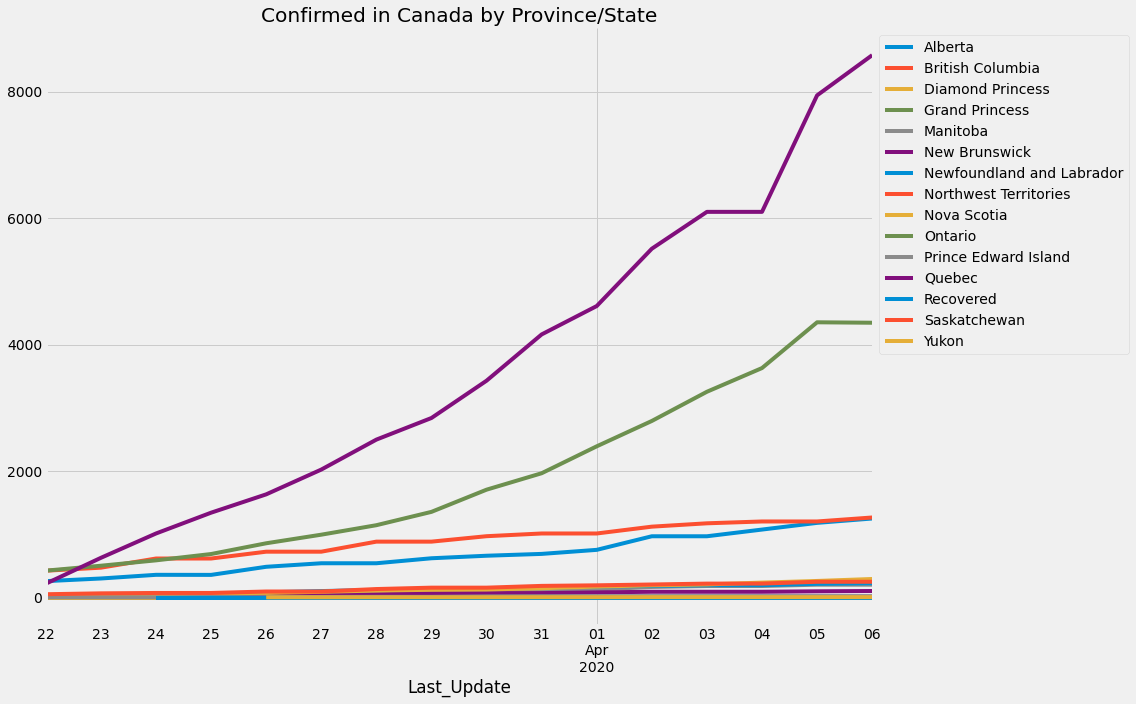

In [6]:
metric = 'Confirmed'
location = 'Canada'
(df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03':,:]
).plot()
plt.legend(bbox_to_anchor=(1, 1))
plt.title('{} in {} by Province/State'.format(metric, location))
plt.tight_layout()
sns.despine()
plt.show()

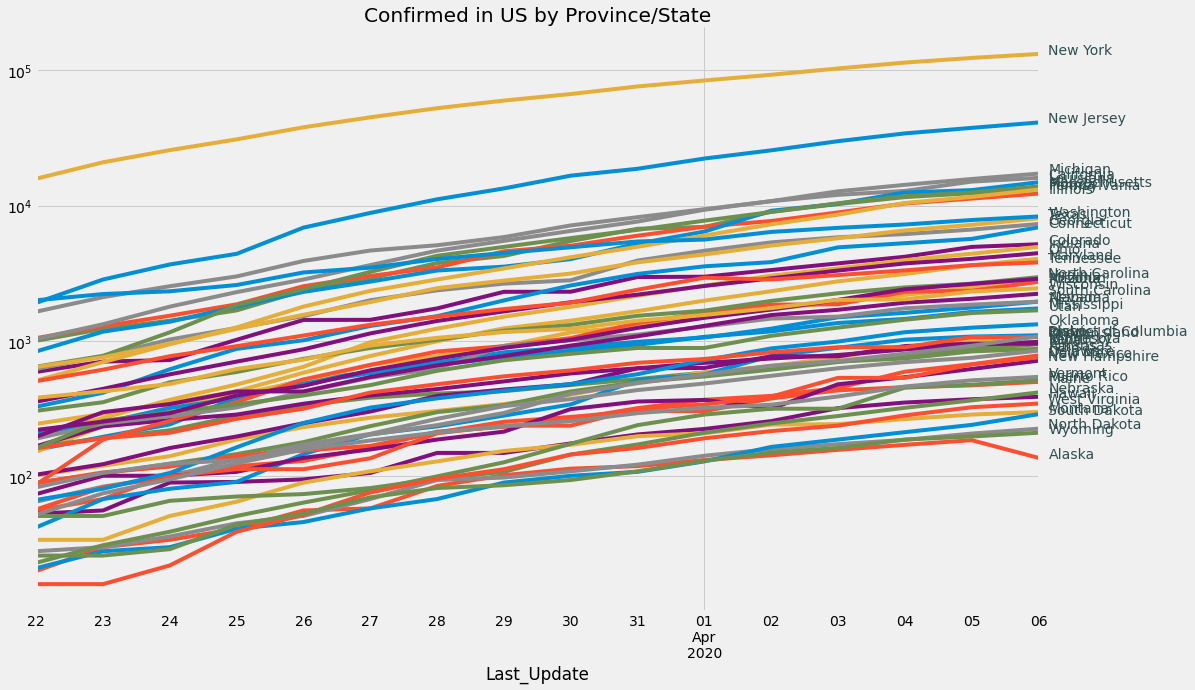

In [7]:
metric = 'Confirmed'
location = 'US'
graphdf = (df_clean.loc[(df_clean.Metric == metric) & (df_clean.Country_Region == location), ['Province_State', 'Value']]
     .reset_index()     # make the index a column for now
     .pivot_table(index='Last_Update', columns='Province_State', values='Value', aggfunc=np.sum)
     .loc['2020-03-22':,:]
     .dropna(axis=1, how='any')
     .drop(['Northern Mariana Islands', 'Virgin Islands', 'Diamond Princess', 'Grand Princess', 'Guam'], axis=1)
)
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None, print_value=False)
plt.title('{} in {} by Province/State'.format(metric, location))
#plt.tight_layout()
sns.despine()
plt.show()


## Alternative one -- just use Combined_Key

In [8]:
#piv1 = df_clean.pivot_table(index=df_clean.index, columns=['Metric','Combined_Key'], values='Value', aggfunc=np.sum)
#piv1.tail() # Note the MultiIndex for the columns (Metric, Combined_Key)

In [9]:
# look at just the deaths (Metric == 'Deaths') aka the top level of the MultiIndex is 'Deaths'

#idx = pd.IndexSlice
#piv1.loc[:,idx['Deaths']]

In [10]:
# Look at just deaths in California
# (must use columns.map() because you can't use .str.endswith on a MultiIndex)

#piv1.loc[:,idx['Deaths', piv1.columns.map(lambda x: x[1].endswith('California, US'))]]

## Alternative Two (PREFERRED) - Use Country, State, Admin2 fields

First, an example of dealing with a column you want to use in a pivot_table that has nulls.

In [11]:
test = pd.DataFrame(
                    [
                        ['US','California',1],
                        ['US','New York',3],
                        ['Italy',np.NaN,10]
                    ],
                    columns = ['country', 'state', 'value'],
                   )
print(test)
print('\nIf you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)')
print(test.pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) )
print('\nNow do a .fillna(value={"column_name":"new_value"}) first and it is OK')
(test
     .fillna(value={'state':'none'})
     .pivot_table( index=test.index, 
            columns=['country','state'], 
            values=['value'], 
            aggfunc=np.sum, 
            dropna=True ) 
)

  country       state  value
0      US  California      1
1      US    New York      3
2   Italy         NaN     10

If you dont fix the null values and use pivot_table specifying a column with null values, youll lose info (as we lose Italy here)
             value         
country         US         
state   California New York
0              1.0      NaN
1              NaN      3.0

Now do a .fillna(value={"column_name":"new_value"}) first and it is OK


value                    
country Italy         US         
state    none California New York
0         NaN        1.0      NaN
1         NaN        NaN      3.0
2        10.0        NaN      NaN

In [12]:
df = (df_clean
          .fillna(value={'Province_State':'none', 'Admin2':'none', 'Country_Region':'none'}) # if you don't do this, countries without state or admin2 will be filtered out.
          .pivot_table(index=df_clean.index, 
                          columns=['Metric','Country_Region','Province_State','Admin2'], 
                          values=['Value'], 
                          aggfunc=np.sum
                      )
     )
df = df.loc['20200322':,:]
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
2020-03-27           104.0   147.0   354.0   263.0    4.0                 7.0   
2020-03-28           104.0   156.0   394.0   304.0    5.0                 7.0   
2020-03-29           114.0   169.0   449.0   327.0    5.0                 7.0   
2020-03-30           164.0   168.0   512.0   352.0    5.0                 7.0   
2020-03-31           165.0   176.0   626.0   354.0    4.0                 7.0   
2020-04-01           228.0   177.0   728.0   366.0    5.0                 7.0   
2020-04-02           257.0   185.0   839.0   403.0    5.0                 9.0   
2020-04-03           265.0   198.0  1004.0   407.0    5.0                15.0   
2020-04-04           282.0   214.0  1031.0   428.0    6.0                15.0   
2020-04-05           327.0   237.0  1078.0   457.0   10.0                15.0   
2020-04-06           338.0   240.0  1160.0   473.0   12.0                15.0   

                                                               \
Metric                                                          
Country_Region Argentina Armenia                    Australia   
Province_State      none    none Australian Capital Territory   
Admin2              none    none                         none   
Last_Update                                                     
2020-03-22         235.0   192.0                         19.0   
2020-03-23         235.0   233.0                         32.0   
2020-03-24         329.0   235.0                         39.0   
2020-03-25         327.0   249.0                         39.0   
2020-03-26         430.0   271.0                         52.0   
2020-03-27         504.0   300.0                         61.0   
2020-03-28         600.0   376.0                         69.0   
2020-03-29         654.0   391.0                         75.0   
2020-03-30         569.0   449.0                         75.0   
2020-03-31         787.0   499.0                         76.0   
2020-04-01         778.0   536.0                         75.0   
2020-04-02         841.0   623.0                         75.0   
2020-04-03         960.0   686.0                         72.0   
2020-04-04        1129.0   720.0                         73.0   
2020-04-05        1127.0   758.0                         66.0   
2020-04-06        1181.0   763.0                         54.0   

                                     ...                                  \
Metric                               ...                Recovered          
Country_Region                       ...           United Kingdom          
Province_State External territories  ... Turks and Caicos Islands   none   
Admin2                         none  ...                     none   none   
Last_Update                          ...                                   
2020-03-22                      0.0  ...                      NaN   93.0   
2020-03-23                      NaN  ...                      NaN  135.0   
2020-03-24                      NaN  ...                      NaN  135.0   
2020-03-25                      NaN  ...                      NaN  135.0   
2020-03-26                      NaN  ...       

#### Trick:  Deleting columns with all zeros

In [13]:
test = pd.DataFrame([[1,0,0,0], [0,0,0,0],[0,0,1,0]], columns=['a','b','c','d'])
print(test)

print('\n"test!=0"  gives a true/false where there are non-zeros')
print(test!=0)

print('\nThe "any" function with axis=0 reduces along row to give true for any column with a true in it')
print((test!=0).any(axis=0))

print('\nNow just select the rows with a true in order to drop the rows with all zeros\ntest.loc[:,(test!=0).any(axis=0)]')
print(test.loc[:,(test!=0).any(axis=0)])

print('\nTo drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead \ntest.loc[(test!=0).any(axis=1),:]')
print(test.loc[(test!=0).any(axis=1),:])

   a  b  c  d
0  1  0  0  0
1  0  0  0  0
2  0  0  1  0

"test!=0"  gives a true/false where there are non-zeros
       a      b      c      d
0   True  False  False  False
1  False  False  False  False
2  False  False   True  False

The "any" function with axis=0 reduces along row to give true for any column with a true in it
a     True
b    False
c     True
d    False
dtype: bool

Now just select the rows with a true in order to drop the rows with all zeros
test.loc[:,(test!=0).any(axis=0)]
   a  c
0  1  0
1  0  0
2  0  1

To drop *rows* of all zero, just change axis=1 and put it in the rows position of loc instead 
test.loc[(test!=0).any(axis=1),:]
   a  b  c  d
0  1  0  0  0
2  0  0  1  0


### Using pd.IndexSlice and slice()

In [14]:
idx = pd.IndexSlice
Any = slice(None)  # could also just use ":", but this is a bit clearer

df.loc[:,idx[Any,Any,Any,Any,'Santa Clara']]

Value                                    
Metric              Active   Confirmed      Deaths   Recovered
Country_Region          US          US          US          US
Province_State  California  California  California  California
Admin2         Santa Clara Santa Clara Santa Clara Santa Clara
Last_Update                                                   
2020-03-22             0.0       263.0         8.0         0.0
2020-03-23             0.0       302.0        10.0         0.0
2020-03-24             0.0       375.0        16.0         0.0
2020-03-25             0.0       459.0        17.0         0.0
2020-03-26             0.0       542.0        19.0         0.0
2020-03-27             0.0       574.0        20.0         0.0
2020-03-28             0.0       591.0        25.0         0.0
2020-03-29             0.0       646.0        25.0         0.0
2020-03-30             0.0       848.0        28.0         0.0
2020-03-31             0.0       890.0        30.0         0.0
2020-04-01             0.0       956.0        32.0         0.0
2020-04-02             0.0      1019.0        36.0         0.0
2020-04-03             0.0      1019.0        36.0         0.0
2020-04-04             0.0      1148.0        39.0         0.0
2020-04-05             0.0      1207.0        39.0         0.0
2020-04-06             0.0      1207.0        39.0         0.0

In [15]:
# eliminate all the columns that are all zero and all the rows that are all zero
# note how using lambda allows us to do this without using temp variables for the 'deaths'/'california' subset
test = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )


# eliminate all the columns that are all zero and all the rows that are all zero
df = (df
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
df

Value                                                     \
Metric              Active                                                      
Country_Region Afghanistan Albania Algeria Andorra Angola Antigua and Barbuda   
Province_State        none    none    none    none   none                none   
Admin2                none    none    none    none   none                none   
Last_Update                                                                     
2020-03-22            38.0    85.0   119.0   111.0    2.0                 1.0   
2020-03-23            38.0    98.0   148.0   131.0    3.0                 3.0   
2020-03-24            72.0   108.0   221.0   162.0    3.0                 3.0   
2020-03-25            80.0   124.0   216.0   186.0    3.0                 3.0   
2020-03-26            88.0   151.0   313.0   220.0    4.0                 7.0   
2020-03-27           104.0   147.0   354.0   263.0    4.0                 7.0   
2020-03-28           104.0   156.0   394.0   304.0    5.0                 7.0   
2020-03-29           114.0   169.0   449.0   327.0    5.0                 7.0   
2020-03-30           164.0   168.0   512.0   352.0    5.0                 7.0   
2020-03-31           165.0   176.0   626.0   354.0    4.0                 7.0   
2020-04-01           228.0   177.0   728.0   366.0    5.0                 7.0   
2020-04-02           257.0   185.0   839.0   403.0    5.0                 9.0   
2020-04-03           265.0   198.0  1004.0   407.0    5.0                15.0   
2020-04-04           282.0   214.0  1031.0   428.0    6.0                15.0   
2020-04-05           327.0   237.0  1078.0   457.0   10.0                15.0   
2020-04-06           338.0   240.0  1160.0   473.0   12.0                15.0   

                                                                               \
Metric                                                                          
Country_Region Argentina Armenia                    Australia                   
Province_State      none    none Australian Capital Territory New South Wales   
Admin2              none    none                         none            none   
Last_Update                                                                     
2020-03-22         235.0   192.0                         19.0           659.0   
2020-03-23         235.0   233.0                         32.0           659.0   
2020-03-24         329.0   235.0                         39.0           807.0   
2020-03-25         327.0   249.0                         39.0          1018.0   
2020-03-26         430.0   271.0                         52.0          1208.0   
2020-03-27         504.0   300.0                         61.0          1394.0   
2020-03-28         600.0   376.0                         69.0          1605.0   
2020-03-29         654.0   391.0                         75.0          1779.0   
2020-03-30         569.0   449.0                         75.0          2020.0   
2020-03-31         787.0   499.0                         76.0          2020.0   
2020-04-01         778.0   536.0                         75.0          2169.0   
2020-04-02         841.0   623.0                         75.0          2284.0   
2020-04-03         960.0   686.0                         72.0          2373.0   
2020-04-04        1129.0   720.0                         73.0          2477.0   
2020-04-05        1127.0   758.0                         66.0          2560.0   
2020-04-06        1181.0   763.0                         54.0          2615.0   

                ...                                                       \
Metric          ...       Recovered                                        
Country_Region  ...  United Kingdom                              Uruguay   
Province_State  ... Channel Islands Gibraltar Isle of Man   none    none   
Admin2          ...            none      none        none   none    none   
Last_Update     ...                                                        

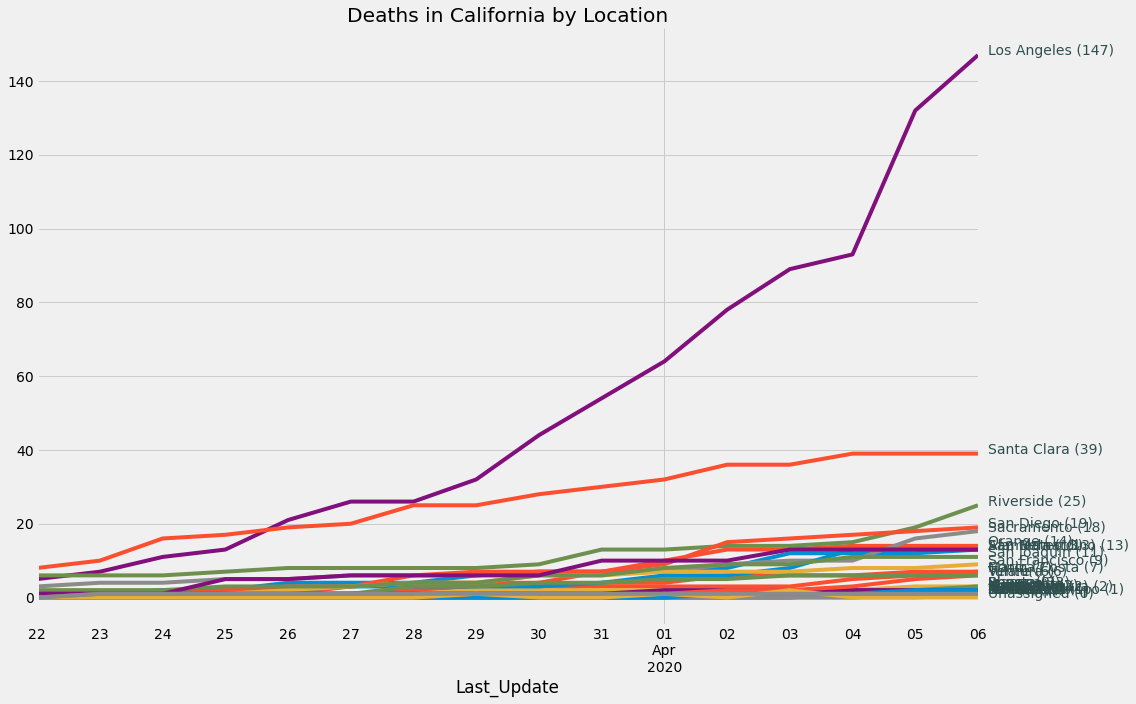

In [16]:
# graph example        
graphdf = (df.loc[:,idx[:,'Deaths',:,'California']]
           .fillna(value=0)                        # replace NaN wit zero -- filters below work better then
           .loc[:,lambda df: (df!=0).any(axis=0)]  # drop columns of all zeros
           .loc[lambda df: (df!=0).any(axis=1),:]   # drop rows of all zeros
       )
ax = graphdf.plot(legend=False)
label_lines(graphdf, ax, tuple_selector=4, print_value=True)
plt.title('Deaths in California by Location')
plt.tight_layout()
sns.despine()
plt.show()

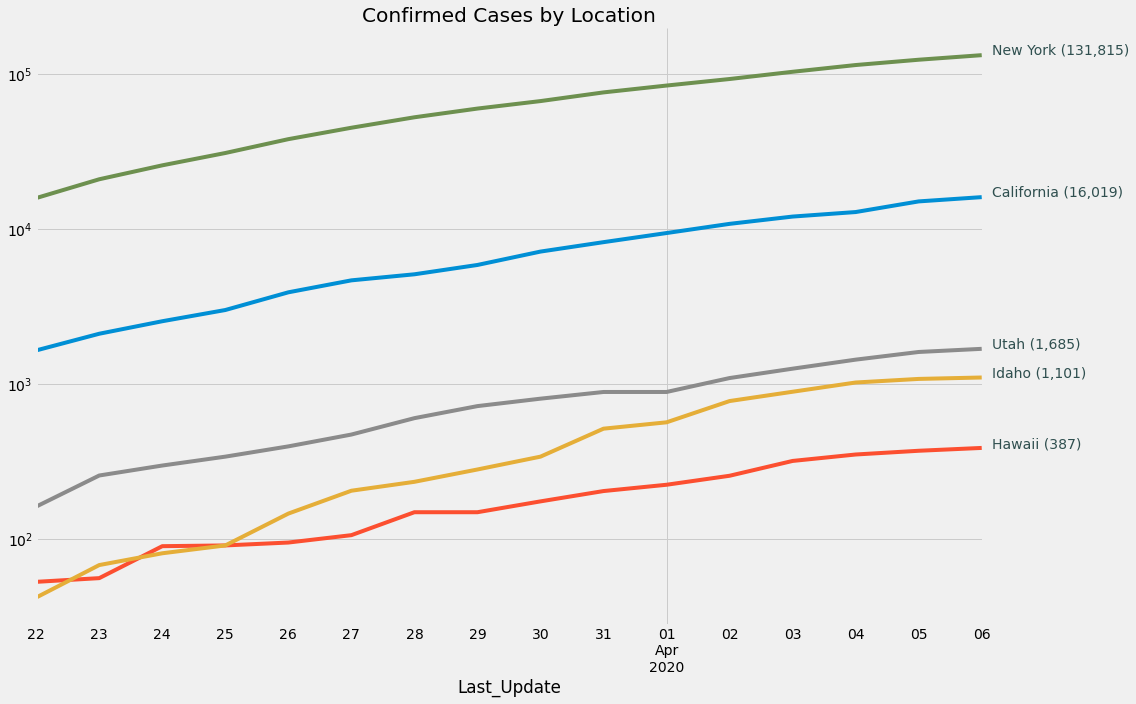

In [17]:
graphdf = (df.loc[:,idx[Any,'Confirmed',Any,['California', 'Utah', 'New York', 'Hawaii', 'Idaho'],Any]]
           .groupby('Province_State', axis='columns')
           .sum()
          )
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, tuple_selector=None, print_value=True)
plt.title('Confirmed Cases by Location')
plt.tight_layout()
sns.despine()
plt.show()


## Creating a table with just a selection of locations (pulled from different levels - countries, states, counties)

In [18]:
locations = {
    'Province_State': idx[:,:,:,['California', 'Utah', 'New York', 'Hawaii', 'Idaho', 'Texas'],:],
    'Country_Region': idx[:,:,['Italy', 'US', 'Spain', 'Japan', 'Singapore'],:,:],
    'Admin2':         idx[:,:,:,:,['Santa Clara', 'Los Angeles']]
}
last_table = None

for level, indexer in locations.items():
    test = (df.loc[:,indexer]
           .groupby(['Metric',level], axis='columns')
           .sum()
       )
    test.rename_axis(('Metric', 'Location'), axis="columns", inplace=True)
    #print(test.info())
    if last_table is None:
        last_table = test
        continue
    last_table = pd.concat([last_table, test], axis=1)
df_select = last_table
df_select

Metric       Confirmed                                              Deaths  \
Location    California Hawaii   Idaho  New York   Texas    Utah California   
Last_Update                                                                  
2020-03-22      1646.0   53.0    42.0   15800.0   643.0   162.0       30.0   
2020-03-23      2108.0   56.0    68.0   20884.0   758.0   257.0       39.0   
2020-03-24      2538.0   90.0    81.0   25681.0   955.0   298.0       50.0   
2020-03-25      2998.0   91.0    91.0   30841.0  1229.0   340.0       65.0   
2020-03-26      3899.0   95.0   146.0   37877.0  1563.0   396.0       81.0   
2020-03-27      4657.0  106.0   205.0   44876.0  1937.0   472.0       94.0   
2020-03-28      5095.0  149.0   234.0   52410.0  2455.0   602.0      110.0   
2020-03-29      5852.0  149.0   281.0   59648.0  2792.0   720.0      124.0   
2020-03-30      7138.0  175.0   340.0   66663.0  3147.0   804.0      146.0   
2020-03-31      8210.0  204.0   515.0   75833.0  3809.0   888.0      173.0   
2020-04-01      9399.0  224.0   566.0   83948.0  4355.0   888.0      199.0   
2020-04-02     10773.0  256.0   776.0   92506.0  5069.0  1092.0      238.0   
2020-04-03     12004.0  319.0   891.0  102987.0  5734.0  1255.0      265.0   
2020-04-04     12837.0  351.0  1022.0  113833.0  6556.0  1435.0      289.0   
2020-04-05     15034.0  371.0  1078.0  123160.0  7209.0  1608.0      348.0   
2020-04-06     16019.0  387.0  1101.0  131815.0  8043.0  1685.0      380.0   

Metric                             ...          Recovered                   \
Location    Hawaii Idaho New York  ...       US     Italy  Japan Singapore   
Last_Update                        ...                                       
2020-03-22     0.0   0.0    117.0  ...    427.0    7024.0  235.0     144.0   
2020-03-23     0.0   0.0    158.0  ...    552.0    7432.0  235.0     152.0   
2020-03-24     1.0   0.0    210.0  ...    706.0    8326.0  285.0     156.0   
2020-03-25     0.0   0.0    285.0  ...    942.0    9362.0  310.0     160.0   
2020-03-26     0.0   3.0    385.0  ...   1209.0   10361.0  359.0     172.0   
2020-03-27     0.0   3.0    527.0  ...   1581.0   10950.0  372.0     183.0   
2020-03-28     0.0   4.0    728.0  ...   2026.0   12384.0  404.0     198.0   
2020-03-29     0.0   5.0    965.0  ...   2467.0   13030.0  424.0     212.0   
2020-03-30     0.0   6.0   1218.0  ...   2978.0   14620.0  424.0     228.0   
2020-03-31     0.0   8.0   1550.0  ...   3873.0   15729.0  424.0     240.0   
2020-04-01     1.0   9.0   1941.0  ...   4757.0   16847.0  472.0     245.0   
2020-04-02     1.0   9.0   2373.0  ...   5926.0   18278.0  472.0     266.0   
2020-04-03     3.0   9.0   2935.0  ...   7087.0   19758.0  514.0     282.0   
2020-04-04     3.0  10.0   3565.0  ...   8407.0   20996.0  514.0     297.0   
2020-04-05     4.0  10.0   4159.0  ...   9619.0   21815.0  514.0     320.0   
2020-04-06     5.0  10.0   4698.0  ...  10783.0   22837.0  575.0     344.0   

Metric                          Confirmed                  Deaths              
Location       Spain       US Los Angeles Santa Clara Los Angeles Santa Clara  
Last_Update                                                                    
2020-03-22    2125.0      0.0       407.0       263.0         5.0         8.0  
2020-03-23    3355.0      0.0       536.0       302.0         7.0        10.0  
2020-03-24    3794.0    348.0       662.0       375.0        11.0        16.0  
2020-03-25    5367.0    361.0       812.0       459.0        13.0        17.0  
2020-03-26    7015.0    681.0      1229.0       542.0        21.0        19.0  
2020-03-27    9357.0    869.0      1465.0       574.0        26.0        20.0  
2020-03-28   12285.0   1072.0      1465.0       591.0        26.0        25.0  
2020-03-29   14709.0   2665.0      1829.0       646.0        32.0        25.0  
2020-03-30   16780.0   5644.0      2474.0       848.0        44.0        28.0  
2020-03-31   19259.0   7024.0      3019.0       890.0        54.0        3

In [19]:
df_select['Confirmed']

Location,California,Hawaii,Idaho,New York,Texas,Utah,Italy,Japan,Singapore,Spain,US,Los Angeles,Santa Clara
Last_Update,,,,,,,,,,,,,
2020-03-22,1646.0,53.0,42.0,15800.0,643.0,162.0,59138.0,1086.0,455.0,28603.0,33746.0,407.0,263.0
2020-03-23,2108.0,56.0,68.0,20884.0,758.0,257.0,63927.0,1128.0,509.0,35136.0,43667.0,536.0,302.0
2020-03-24,2538.0,90.0,81.0,25681.0,955.0,298.0,69176.0,1193.0,558.0,39885.0,53740.0,662.0,375.0
2020-03-25,2998.0,91.0,91.0,30841.0,1229.0,340.0,74386.0,1307.0,631.0,49515.0,65778.0,812.0,459.0
2020-03-26,3899.0,95.0,146.0,37877.0,1563.0,396.0,80589.0,1387.0,683.0,57786.0,83836.0,1229.0,542.0
2020-03-27,4657.0,106.0,205.0,44876.0,1937.0,472.0,86498.0,1468.0,732.0,65719.0,101657.0,1465.0,574.0
2020-03-28,5095.0,149.0,234.0,52410.0,2455.0,602.0,92472.0,1693.0,802.0,73235.0,121478.0,1465.0,591.0
2020-03-29,5852.0,149.0,281.0,59648.0,2792.0,720.0,97689.0,1866.0,844.0,80110.0,140886.0,1829.0,646.0
2020-03-30,7138.0,175.0,340.0,66663.0,3147.0,804.0,101739.0,1866.0,879.0,87956.0,161807.0,2474.0,848.0


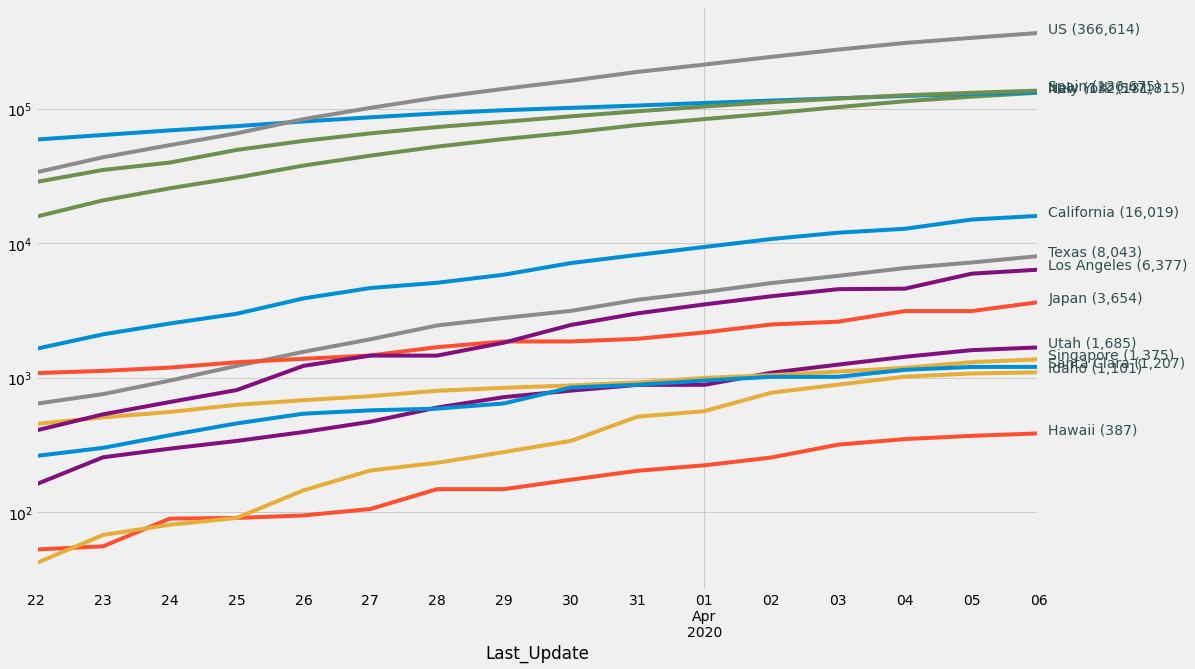

In [20]:
graphdf = df_select['Confirmed']
ax = graphdf.plot(logy=True, legend=False)
label_lines(graphdf, ax, print_value=True)